In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"

#toggle if GPU runs out of memory
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import random
import datetime, os
import cv2, pickle, time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.optimize as optimize
import glob
import pandas as pd
import tifffile as tiff

from pathlib import Path

In [11]:
grades = np.array([3,4,5,4,4,5,3,5,5,4,4])
creds_ = np.array([4,4,4,3,4,4,3,4,4,3,3])

In [12]:
(5*4*4 + 4*2*4 + 4*3*3 + 3*1*4 + 3*1*3)/sum(creds_)

4.225

In [2]:
def conv_layer(feat, filters, kernel_size, strides, training, reg = None, act_reg = None, name = None, trainable = True, padding = "same", relu = True):
    conv = tf.compat.v1.layers.Conv2D(filters=filters,
                            kernel_size=kernel_size,
                            strides=strides,
                            padding=padding,
                            name=name,
                            trainable=trainable,
                            kernel_regularizer=reg,
                            activity_regularizer=act_reg)(feat)

    bn = tf.compat.v1.layers.batch_normalization(conv, center=True, scale=True, training=training)
    
    if relu:
        return tf.nn.leaky_relu(bn, alpha=0.1)
    else:
        return bn
 
def pooling(feat):
    return tf.compat.v1.layers.MaxPooling2D(pool_size=3, strides=2)(feat)

def resnet_block(feat, filters, kernel_size, strides, training, reg, relu = True, trainable = True):
    conv = tf.compat.v1.layers.Conv2D(filters,kernel_size,strides,padding="same", trainable = trainable, kernel_regularizer=reg)(feat)
    bn = tf.compat.v1.layers.batch_normalization(conv, training=training, trainable = trainable)
    if relu:
        return tf.nn.leaky_relu(bn, alpha=0.1)
    else:
        return bn

def block(feat, filters, training, reg=None, stride = 1):

    conv0 = resnet_block(feat, filters, 1, stride, training, reg)
    conv1 = resnet_block(conv0, filters, 3, 1, training, reg)

    if feat.shape[-1] == filters*4:
        conv2 = resnet_block(conv1, filters*4, 1, 1, training, reg, relu = False) + feat
    else:
        conv2 = resnet_block(conv1, filters*4, 1, 1, training, reg, relu = False) + \
                resnet_block(feat, filters*4, 1, stride, training, reg, relu = False)
    return tf.nn.leaky_relu(conv2, alpha=0.1)

def sub_model(features, training, l2_reg = None, ):
    conv0 = resnet_block(features, 64, 7, 1, training, l2_reg)
    pool0 = pooling(conv0)

    block0 = block(pool0, 64, training, l2_reg, stride = 2)
    block1 = block(block0, 64, training, l2_reg)
    block2 = block(block1, 64, training, l2_reg)

    block3 = block(block2, 128, training, l2_reg, stride = 2)
    block4 = block(block3, 128, training, l2_reg)
    block5 = block(block4, 128, training, l2_reg)
    block6 = block(block5, 128, training, l2_reg)
    block_special = block(block6, 256, training, l2_reg, stride = 2)

    for i in range(22):
        block_special = block(block_special, 256, training, l2_reg)

    block13 = block(block_special, 512, training, l2_reg, stride = 2)
    block14 = block(block13, 512, training, l2_reg)
    block15 = block(block14, 512, training, l2_reg)

    return block15

def resnet(features, labels, mode):
    training = False
    if mode == tf.estimator.ModeKeys.TRAIN:
        training = True

    feature1 = features[..., :3]
    feature2 = tf.expand_dims(features[..., 3], -1)
    features1 = tf.map_fn(lambda frame: tf.image.per_image_standardization(frame), feature1)
    features2 = tf.map_fn(lambda frame: tf.image.per_image_standardization(frame), feature2)

    l2_reg = None
    
    out1 = sub_model(features1, training, l2_reg)
    out2 = sub_model(features2, training, l2_reg)
    avg1 = tf.keras.layers.GlobalAveragePooling2D()(out1)
    avg2 = tf.keras.layers.GlobalAveragePooling2D()(out2)
    merge = tf.concat((avg1, avg2), axis = -1)

    out = tf.compat.v1.layers.dense(merge, 2048)
    out_bn = tf.compat.v1.layers.batch_normalization(out, center=True, scale=True, training=training)
    out_relu = tf.nn.relu(out_bn)
    logits = tf.keras.layers.Dense(11, activation=None)(out_relu)

    predictions = {
      "classes": tf.argmax(input=tf.nn.softmax(logits), axis=1),
      "probabilities": tf.nn.softmax(logits),
      "feats": out_relu
    }
    
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

def train_input_fn():
    dataset =  tf.compat.v1.data.TFRecordDataset(train_filenames)
 
    dataset = dataset.map(parser)
    dataset = dataset.shuffle(buffer_size=2048)
    dataset = dataset.batch(batch_size=batch_size)
    dataset = dataset.repeat(1)
 
    return dataset
 
def eval_input_fn():
    dataset =  tf.compat.v1.data.TFRecordDataset(eval_filenames)
    dataset = dataset.map(parser)
    dataset = dataset.batch(batch_size=batch_size*2)
    
    return dataset
 
def predict(data, model):
    data = np.asarray(data).astype(np.float32)
    predict_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(x=data, shuffle = False)
    res = list(model.predict(input_fn=predict_input_fn, yield_single_examples=False))
    
    return res[0]

def sharpen(image, P):
    def get_sharpW(image, P):
        P_lr = cv2.resize(P, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC)

        if P_lr.shape[0] < image.shape[0]:
            image = image[:P_lr.shape[0],:, :]
        else:
            P_lr = P_lr[:image.shape[0], :]

        if P_lr.shape[1] < image.shape[1]:
            image = image[:,:P_lr.shape[1], :]
        else:
            P_lr = P_lr[:,:image.shape[1]]

        shape = image.shape
        return optimize.lsq_linear(image.reshape(shape[0]*shape[1],3), P_lr.flatten(), (0,1), lsq_solver = 'lsmr').x
    
    W = get_sharpW(image, P)
    P_lr = cv2.resize(P, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC)
    shape = image.shape
    V = P_lr-np.sum(W*image, axis = -1)

    V_hr = cv2.resize(V, None, fx=2, fy=2, interpolation = cv2.INTER_CUBIC)
    P_hr = P - V_hr
    
    S_hr = cv2.resize(image, None, fx=2, fy=2, interpolation = cv2.INTER_CUBIC)
    I_hr = np.sum(W*S_hr, axis = -1)

    out = np.zeros(S_hr.shape)
    out[:,:,0] = S_hr[:,:,0] + P_hr - I_hr
    out[:,:,1] = S_hr[:,:,1] + P_hr - I_hr
    out[:,:,2] = S_hr[:,:,2] + P_hr - I_hr


    return out

def encode_landCover(img):
    w, h = img.shape
    u,inv = np.unique(img,return_inverse = True)
    colored_img = np.array([classes.get(x, 0) for x in u])[inv].reshape(img.shape)
    return np.uint8(colored_img)

def example_input_fn(generator):
    """ An example input function to pass to predict. It must take a generator as input """

    def _inner_input_fn():
        dataset = tf.compat.v1.data.Dataset.from_generator(generator, output_types=(tf.float32), output_shapes=(128,128,4)).batch(1)
        iterator = dataset.make_one_shot_iterator()
        features = iterator.get_next()
        return features

    return _inner_input_fn

def my_service():
    start, end = 1, 100
    for number in range(start, end):
        yield number


class TFEstimatorServe(object):

    def __init__(self, estimator, input_fn):
        self.data = []
        self.estimator = estimator
        self.input_fn = input_fn(self.data_generator)
        self.results = self.estimator.predict(input_fn=self.input_fn, yield_single_examples=True)
        self.closed = False
    
    def data_generator(self):

        while not self.closed:
            data = self.data.pop(0)
            yield data[:,:,:4]

    def predict(self, data):

        self.data = data
        predictions = []
        for _ in range(len(data)):
            res = next(self.results)
            predictions.append((res['feats'], res['classes']))
        return predictions

    def close(self):
        self.closed = True
        try:
            next(self.predictions)
        except:
            print("Exception in fast_predict. This is probably OK")

FOLDER = './chkp/pop_pred/final/'

my_checkpointing_config = tf.estimator.RunConfig(
    save_checkpoints_steps = 2048000,
    keep_checkpoint_max = 10,
    log_step_count_steps = 100)

model = tf.estimator.Estimator(resnet, model_dir = FOLDER, config = my_checkpointing_config)

INFO:tensorflow:Using config: {'_model_dir': './chkp/pop_pred/final/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 2048000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 10, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [3]:
channel_names = ['B1.tif', 'B2.tif', 'B3.tif', 'B4.tif', 'B5.tif', 'B6_VCID_1.tif', 'B7.tif', 'B8.tif']
folder = './2021/data/test/'
folders = []
files = []
raw_file_names = []

#Choose a desired city and set coordinates
city = "Yakutsk"
file_name = glob.glob("./data/test/"+city+"/*.tif")[0][:-6] #SLC
for i in range(len(channel_names)):
    files.append(file_name + channel_names[i])

# x1,x2 = 1500, 3500 #SLC
# x1,x2 = 500, 2100 #SanAnt
# x1,x2 = 2500, 4500 #Tulsa
# x1,x2 = 2000,3920 #LA
# x1,x2 = 1700,1400 #NY
# x1,x2 = 5000,3000 #Portland
# x1,x2 = 4900,1400 #Denver
x1,x2 = 1000, 4000 #Yakutsk

y1 = x1+1280
y2 = x2+1280

full_image_with_pop_R = tiff.imread(files[0])[x1:y1,x2:y2]
full_image_with_pop_G = tiff.imread(files[1])[x1:y1,x2:y2]
full_image_with_pop_B = tiff.imread(files[2])[x1:y1,x2:y2]
full_image_with_pop_P = tiff.imread(files[7])[x1*2:y1*2,x2*2:y2*2]
LC_map = cv2.imread('./images/unet/out' + city + '_encoded.png', 0)[..., np.newaxis]

full_image_with_pop = sharpen(np.stack((full_image_with_pop_R, full_image_with_pop_G, full_image_with_pop_B), axis = 2), 
                              full_image_with_pop_P)

full_image = np.append(full_image_with_pop, LC_map, axis=2)

imgs = []
for i in range(20):
    for j in range(20):
        imgs += [full_image[128*i:128*(i+1), 128*j:128*(j+1), :]]

del full_image_with_pop, full_image_with_pop_R, full_image_with_pop_G, full_image_with_pop_B, full_image_with_pop_P

fast_predict = TFEstimatorServe(model, example_input_fn)
out = fast_predict.predict(imgs)
fast_predict.close()
    
del imgs

regs = [None]
for i in range(1,11):
    filename = './chkp/reg/model_'+str(i)+'.sav'
    regs += [pickle.load(open(filename, 'rb'))]

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead
Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.
INFO:tensorflow:Calling model_fn.


C:\Users\User\miniconda3\envs\myenv\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\normalization.py:308: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  '`tf.layers.batch_normalization` is deprecated and '
C:\Users\User\miniconda3\envs\myenv\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
C:\Users\User\miniconda3\envs\myenv\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instea

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./chkp/pop_pred/final/model.ckpt-23040
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Exception in fast_predict. This is probably OK


In [8]:
pops = 0
pops_arr = np.zeros(len(out))
for i in range(len(out)):
    reg = regs[out[i][1]]
    pop = 0
    if reg:
        pop = reg.predict(out[i][0][np.newaxis,...])
    pops += pop
    pops_arr[i] = pop
    
print("Infred population number: ", pops)

Infred population number:  [93219.4099614]


True

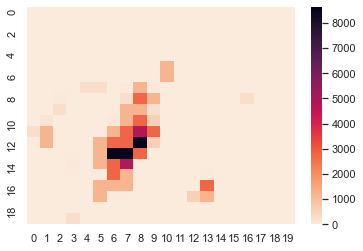

In [5]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
from matplotlib.colors import Normalize

out_matr = np.reshape(pops_arr, (20,20))
ax = sns.heatmap(out_matr, cmap = sns.cm.rocket_r)

norm = Normalize(vmin=min(pops_arr), vmax=max(pops_arr))
rgba_values = sns.cm.rocket_r(norm(out_matr))

out_img = full_image.copy()

for i in range(20):
    for j in range(20):
        temp = out_img[128*i:128*(i+1), 128*j:128*(j+1), :3]
        rmap = np.zeros((128,128,3))
        rmap += 255*rgba_values[i,j,:3]
        dst = cv2.addWeighted(temp, 1, rmap[:,:,::-1], 0.5, 0)
        out_img[128*i:128*(i+1), 128*j:128*(j+1), :3] = dst

out_img[out_img>255] = 255
cv2.imwrite('./images/unet/out'+city+'_reg.png', np.uint8(out_img)[:,:,:3]) 